# Saliency Visualization

Helpful Links:
https://fairyonice.github.io/Saliency-Map-with-keras-vis.html
https://www.machinecurve.com/index.php/2019/11/25/visualizing-keras-cnn-attention-saliency-maps/#introducing-keras-vis

In [1]:
!pip3 install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps

  Cloning git://github.com/raghakot/keras-vis.git to /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-x_qpyfoe
  Running command git clone -q git://github.com/raghakot/keras-vis.git /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-req-build-x_qpyfoe
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30855 sha256=4c970e34ddbf720d256e7ef2c4b66df7d60b61e29db52a9575b7eada1b5370ec
  Stored in directory: /private/var/folders/0n/cnsbrwp110n1_232_8jnhbz80000gn/T/pip-ephem-wheel-cache-042uywj5/wheels/d4/f2/90/2fb26be5bf8493b1fadd7c991dc12b9c47cc47c604d214566a
Successfully built keras-vis
  Attempting uninstall: keras-vis
    Found existing installation: keras-vis 0.5.0
    Uninstalling keras-vis-0.5.0:
      Successfully uninstalled keras-vis-0.5.0


In [2]:
!pip3 install -r requirements.txt

import keras
import vis

from keras import activations
from keras.models import load_model
from keras.utils import to_categorical, CustomObjectScope

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from models import AlphaNet

import numpy as np
from numpy import loadtxt

from tools import *
from train import *

from vis.visualization import visualize_saliency
from vis.utils import utils


ERROR: Could not find a version that satisfies the requirement torch==1.5.0+cu101 (from -r requirements.txt (line 15)) (from versions: 0.1.2, 0.1.2.post1, 0.1.2.post2, 0.4.1, 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.1.0.post2, 1.2.0, 1.3.0, 1.3.0.post2, 1.3.1, 1.4.0, 1.5.0)
ERROR: No matching distribution found for torch==1.5.0+cu101 (from -r requirements.txt (line 15))


Using TensorFlow backend.


In [3]:
assert int(tf.__version__[0]) >= 2
from skimage.transform import resize

In [16]:
# load model
custom_metrics = {
    "top3_accuracy": top3_acc,
    "top5_accuracy": top5_acc
}
model = load_model('../BravoNet.h5', custom_objects=custom_metrics) 
model.summary()


Model: "BravoNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet18 (Model)             (None, 3, 3, 512)         11186889  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               102600    
Total params: 11,289,489
Trainable params: 11,281,547
Non-trainable params: 7,942
_________________________________________________________________


In [5]:
X_train, y_train = load_data()
X_val, y_val = load_data("val")
X_test, _ = load_data("test")

y_train = to_categorical(y_train, 200)
y_val = to_categorical(y_val, 200)

Loading train data

Finished loading train data

Loading val data

Finished loading val data

Loading test data

Finished loading test data



In [6]:
boxes = get_box_dict_val()
assert(len(boxes) == len(X_val))


Loading bounding boxes

Done



In [7]:
labels = get_label_dict()
words = get_word_labels()

test_images = os.listdir("data/tiny-imagenet-200/test/images/")
assert len(X_test) == len(test_images)

Loading labels

Done

Loading words

Done



In [17]:
with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):
    layer_index = -1
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)  

[[0.15437448 0.31040612 0.27084112 ... 0.1164213  0.06065691 0.06852683]
 [0.09036874 0.18932633 0.18377504 ... 0.02667846 0.09768273 0.09459983]
 [0.11231241 0.13779195 0.23336934 ... 0.04863157 0.06262042 0.03999777]
 ...
 [0.03381705 0.10220233 0.22578555 ... 0.02067423 0.02088248 0.01508957]
 [0.10450502 0.15659912 0.12110999 ... 0.05698701 0.02099706 0.01964468]
 [0.0503808  0.12217101 0.14050585 ... 0.05110147 0.         0.07166651]]


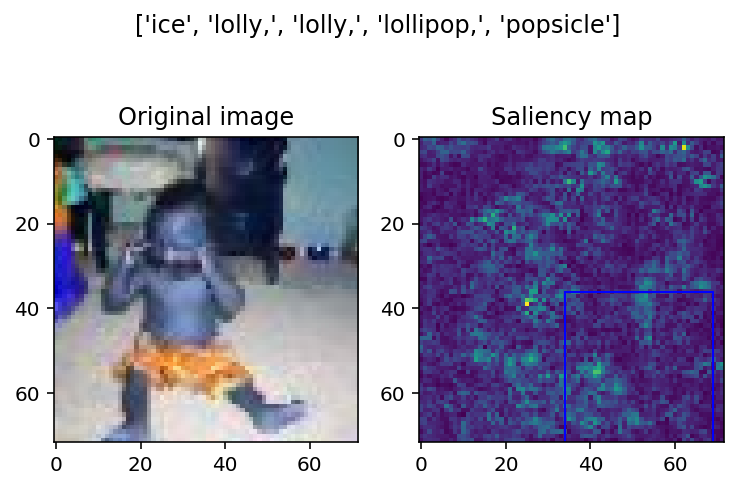

[[0.16099238 0.13938496 0.08023949 ... 0.05434212 0.03183724 0.00812881]
 [0.07552567 0.01373686 0.06515484 ... 0.09058089 0.03068205 0.04998196]
 [0.13097163 0.10871267 0.39658314 ... 0.11538991 0.13321204 0.03133107]
 ...
 [0.01780581 0.14927877 0.04365893 ... 0.05912115 0.06052101 0.0393826 ]
 [0.04651157 0.09872331 0.09771702 ... 0.0194146  0.05825933 0.01197889]
 [0.03177584 0.01444381 0.0277762  ... 0.03111022 0.0787908  0.13438147]]


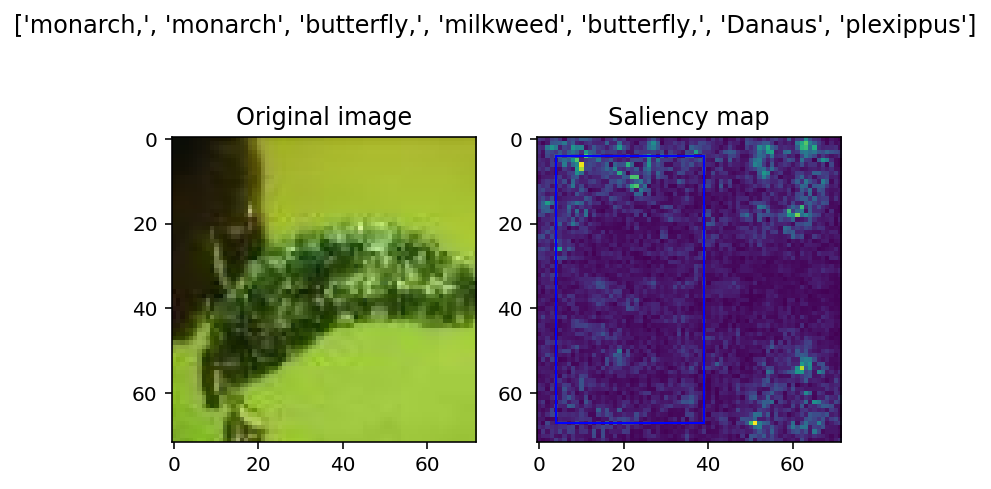

[[0.10110439 0.07353831 0.07450968 ... 0.0562768  0.08029653 0.04280549]
 [0.08314094 0.09215669 0.09530798 ... 0.0966708  0.13991931 0.06319498]
 [0.06080491 0.04982303 0.07446717 ... 0.19791478 0.08934555 0.08118571]
 ...
 [0.03416436 0.1007925  0.0216161  ... 0.02531494 0.02201671 0.0104604 ]
 [0.03189812 0.02275103 0.02824412 ... 0.03552889 0.03475103 0.01740905]
 [0.03419051 0.04332179 0.04696235 ... 0.02409793 0.01384108 0.02095115]]


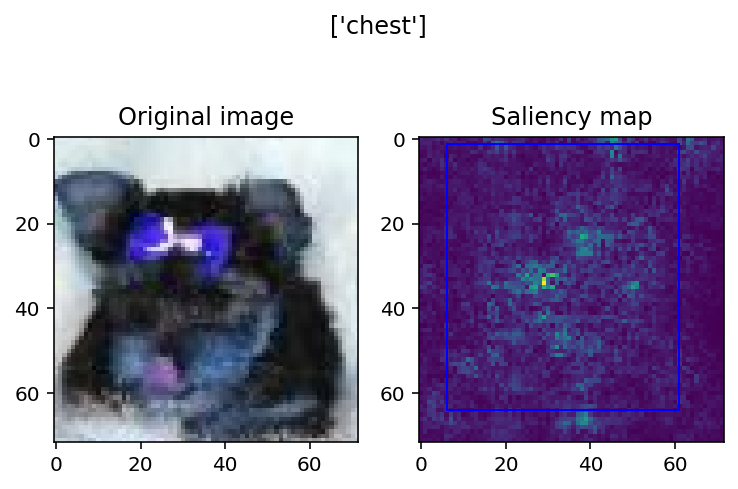

[[0.0533597  0.05164238 0.06886035 ... 0.0198299  0.00316619 0.01997601]
 [0.16340812 0.04911796 0.03627847 ... 0.02394457 0.00149396 0.01239128]
 [0.15384513 0.06200662 0.12086745 ... 0.02924053 0.01664295 0.00605057]
 ...
 [0.24339847 0.22290371 0.2115389  ... 0.06891251 0.17993213 0.08417752]
 [0.1980012  0.14309126 0.12865476 ... 0.18205462 0.1299251  0.01515702]
 [0.116626   0.13159256 0.16289006 ... 0.12126095 0.07328478 0.03417571]]


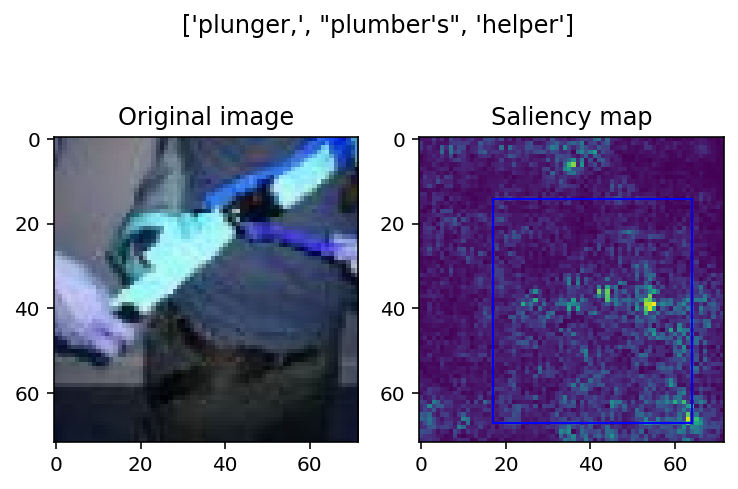

[[0.02403006 0.07917001 0.08795172 ... 0.04378951 0.09296435 0.02122426]
 [0.05254049 0.00886922 0.05597347 ... 0.20017608 0.19372535 0.12296632]
 [0.05922152 0.06045443 0.03872067 ... 0.19151837 0.25587305 0.17170605]
 ...
 [0.08713793 0.06255533 0.06608541 ... 0.13800636 0.05927155 0.03399089]
 [0.08359105 0.08964207 0.02591236 ... 0.04790167 0.03151865 0.03294434]
 [0.06349251 0.10316305 0.08257329 ... 0.05145799 0.02520423 0.01721568]]


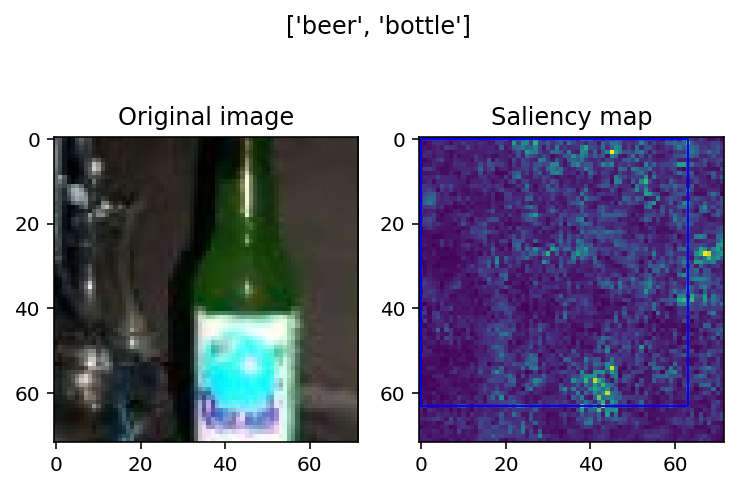

[[0.03978894 0.10848863 0.06550615 ... 0.05254237 0.05364075 0.03761596]
 [0.05897949 0.14447416 0.16055089 ... 0.025958   0.05412645 0.02915959]
 [0.11360405 0.13969739 0.16446647 ... 0.08661334 0.02657201 0.        ]
 ...
 [0.1663475  0.2356795  0.25964934 ... 0.03034178 0.14074835 0.07336428]
 [0.07712533 0.20843314 0.10090329 ... 0.13647665 0.06970539 0.06890944]
 [0.11739387 0.16850065 0.1856     ... 0.2828561  0.00963516 0.05646367]]


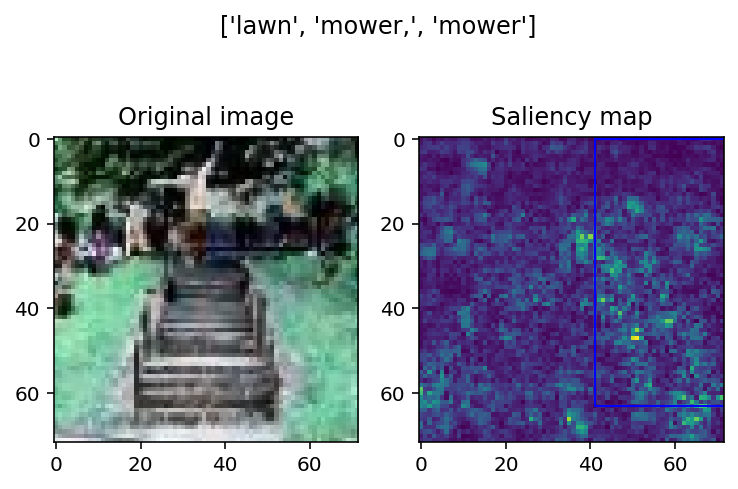

[[0.03291292 0.02641869 0.03261556 ... 0.01230447 0.00567246 0.03298313]
 [0.02883076 0.02947922 0.0338252  ... 0.0641044  0.04139432 0.01169391]
 [0.04500761 0.03762165 0.03591215 ... 0.10980897 0.02177247 0.04406861]
 ...
 [0.02596597 0.03309521 0.0720076  ... 0.02011202 0.0057685  0.00831473]
 [0.04936983 0.06302065 0.05114415 ... 0.0347554  0.00229526 0.0015608 ]
 [0.0304532  0.05421357 0.04736859 ... 0.00700118 0.0081831  0.00727855]]


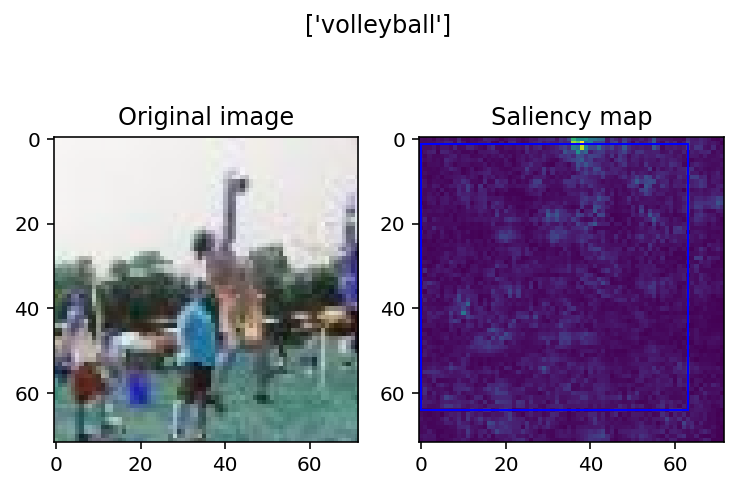

[[0.11613193 0.06792089 0.06172036 ... 0.0116517  0.0146086  0.06843355]
 [0.01721992 0.02693766 0.09276703 ... 0.10032032 0.16487099 0.17415799]
 [0.07993834 0.13211109 0.06565993 ... 0.26073447 0.0229512  0.13729505]
 ...
 [0.01244716 0.04799432 0.02839431 ... 0.3770706  0.05180898 0.19270502]
 [0.12460063 0.07612194 0.02830348 ... 0.1222505  0.624814   0.18094738]
 [0.0237986  0.0724007  0.04741108 ... 0.16711341 0.45399877 0.04541962]]


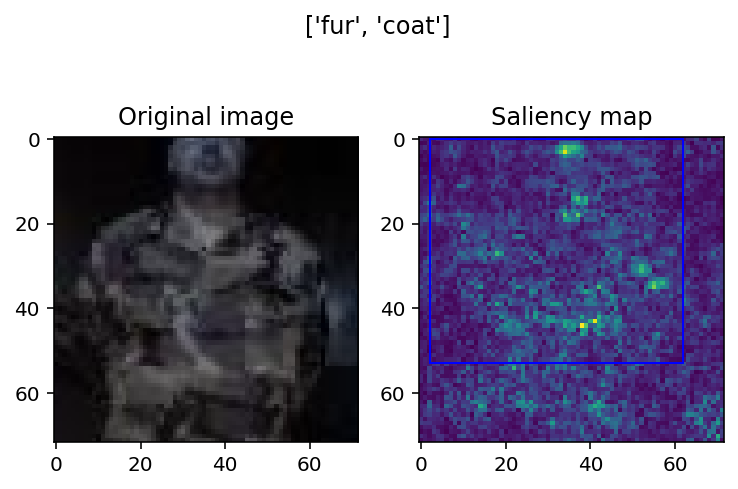

[[0.14974822 0.1860934  0.24254239 ... 0.11752216 0.03933676 0.14447278]
 [0.09573622 0.19898222 0.06039748 ... 0.07398754 0.22038819 0.05499595]
 [0.34593195 0.5302806  0.2762424  ... 0.1366579  0.05270341 0.17851341]
 ...
 [0.09674978 0.15548718 0.2314237  ... 0.07551035 0.03956786 0.0465897 ]
 [0.17225713 0.09754168 0.10750523 ... 0.05672333 0.12422532 0.03946092]
 [0.25701827 0.14253543 0.2647803  ... 0.04582701 0.04568033 0.06074791]]


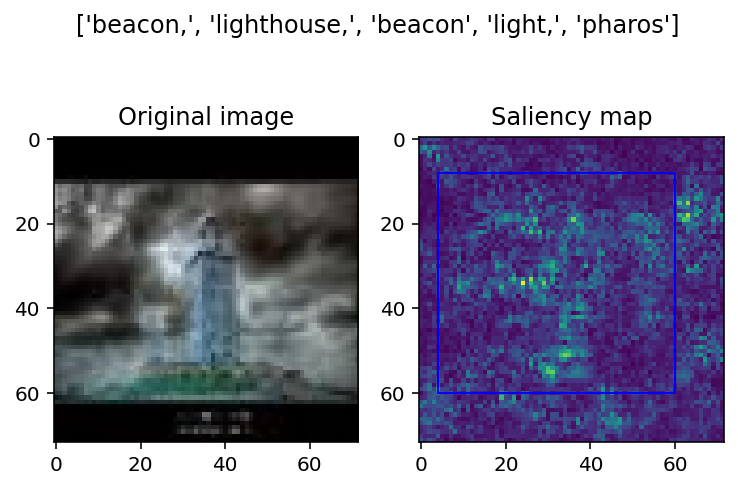

[[0.31524733 0.22039732 0.06094475 ... 0.03674842 0.0010101  0.11095095]
 [0.13245839 0.13679601 0.09053957 ... 0.11389804 0.1058367  0.02993932]
 [0.10158338 0.17984255 0.14644095 ... 0.1568377  0.0523176  0.08866075]
 ...
 [0.06309827 0.06160984 0.03910154 ... 0.04316589 0.03496576 0.03873209]
 [0.04299545 0.12119698 0.14345615 ... 0.06090401 0.03562159 0.03362216]
 [0.19316675 0.02897831 0.04349614 ... 0.04629648 0.02425048 0.01005248]]


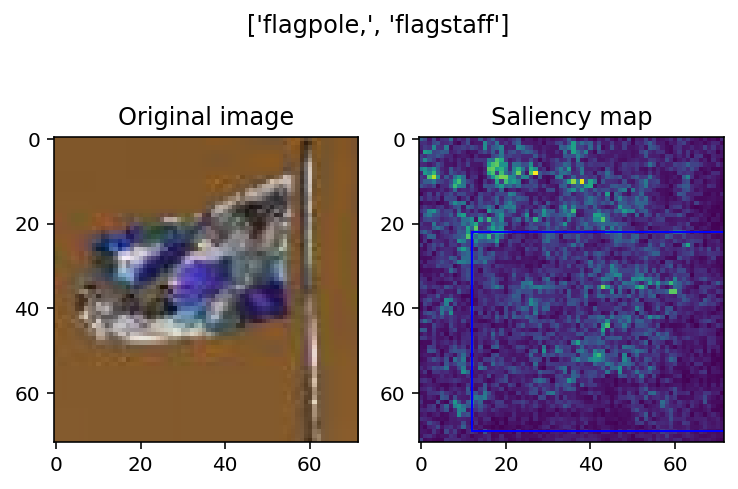

In [20]:
# indices_to_visualize = [ 5, 19, 38, 82, 111, 76, 194 ]
indices_to_visualize = np.random.choice(len(X_val), 10)

with CustomObjectScope({"top3_accuracy": top3_acc, "top5_accuracy": top5_acc,}):

    for index_to_visualize in indices_to_visualize:
        # Get input
        input_image = X_val[index_to_visualize]
        input_class = np.argmax(y_val[index_to_visualize])
        
        # Matplotlib preparations
        fig, axes = plt.subplots(1, 2)
        
        # Generate visualization
        input_image = resize(input_image, (72, 72, 3))
        visualization = visualize_saliency(model, layer_index, filter_indices=input_class, seed_input=input_image)

        y_pred = model.predict(input_image[np.newaxis,...])
        class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]

        class_idx = class_idxs_sorted[0]

        axes[0].imshow(input_image) 

        axes[0].set_title('Original image')
        axes[1].imshow(visualization)
        print(visualization)
        b = boxes['val_'+str(index_to_visualize)+'.JPEG']
        rect = patches.Rectangle((int(b[0]),int(b[1])),int(b[2]),int(b[3]),linewidth=1,edgecolor='b',facecolor='none')
        axes[1].add_patch(rect)
        axes[1].set_title('Saliency map')
        fig.suptitle(words[labels[class_idx]])
        fname = './saliency'+str(index_to_visualize)+'.png'
        plt.savefig(fname, bbox_inches='tight')
        plt.show()


        